In [1]:
# Import required libraries, modules, and functions
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.cluster import KMeans

from env import get_db_url
import wrangle_zillow
import model

# Set up significance level and plot parameters globally
alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

# Project Introduction and Goal

- The goal of this project was to identify factors affecting errors in the model used by Zillow to estimate single family home prices in 2017. 
- The results of this project will be used to improve the model used to estimate prices and guide future data collection efforts. If we know log errors are higher for certain home characteristics we can investigate the reasons for higher errors, develop a mitigation plan, and improve model predictions.
- This specific project incorporated KMeans clustering models to examine the effect of multiple variable combinations on log error

# Wrangling
- Data acquired from server or cached csv file
- Handling of missing values documented in function in wrangle_zillow.py
    - For binary values with only 1 and null options the nulls were filled as 0s
- Outliers greater than 3.0 multiples from IQR were removed to focus the dataset
- Data split into train, validate, and test sets
- Additional features added to each data set:
    - binning bedroom counts, bathroom counts, home age, etc.

In [2]:
# Acquire and prepare data from server or csv.
df = wrangle_zillow.wrangle_zillow()
# Handle missing values and remove outliers

df = wrangle_zillow.handle_missing_zillow_values(df)
df = wrangle_zillow.remove_outliers(df, 3.0, ['bathroom', 'bedroom','square_feet','lot_size','tax_value'])

# Split data into train, validate, and test sets
train, validate, test = wrangle_zillow.split_data(df)

# Add features to each dataset
train, validate, test = model.add_features(train, validate, test)

Using cached data
Shape before handling missing values: (77380, 61)
Shape after removing nulls: (50906, 53)
Final shape after removing outliers (46361, 53)
Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


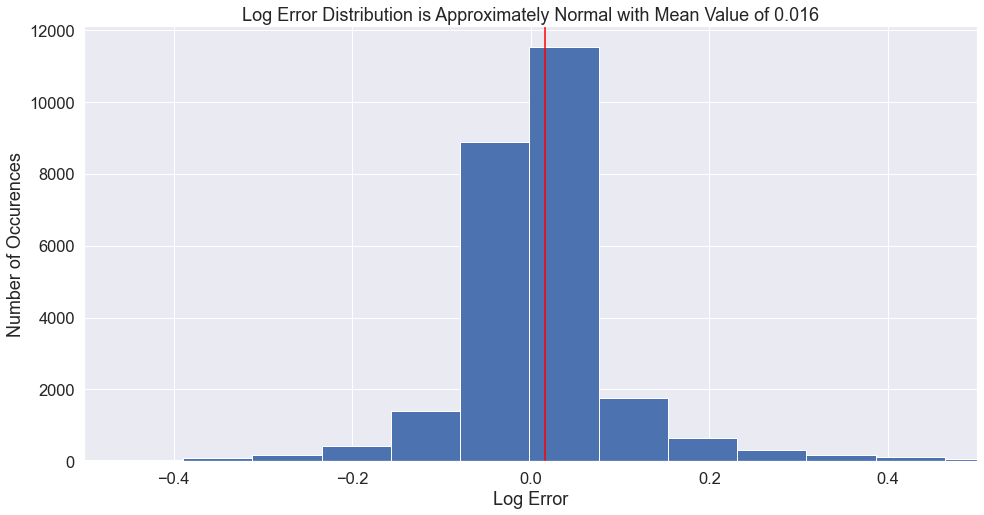

In [3]:
# Plot distribution of log error
train.logerror.hist(bins=100)
plt.xlim(-0.5,0.5)
log_error_mean = train.logerror.mean()
plt.axvline(log_error_mean, color='red')
plt.title(f"Log Error Distribution is Approximately Normal with Mean Value of {log_error_mean:.3f}")
plt.xlabel("Log Error")
plt.ylabel("Number of Occurences")
plt.show()

### *For the purpose of this project the absolute value of log error was taken and used for exploration, so both positive and negative log error are treated equally. A future iteration may go back and see if some factors result in greater positive log error than negative log error.

# Exploration
- Initially examine correlations between continuous variables and target. No variables showed strong correlation with absolute log error

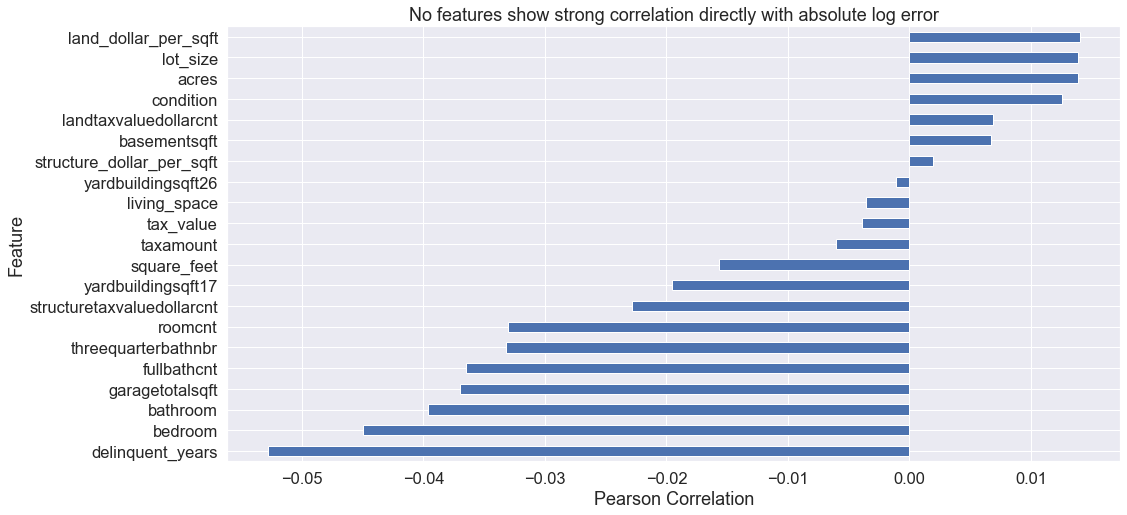

In [4]:
continuous = ['basementsqft', 'bathroom', 'bedroom','condition','square_feet','fullbathcnt', 'garagetotalsqft','lot_size','roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17','yardbuildingsqft26','structuretaxvaluedollarcnt', 'tax_value','landtaxvaluedollarcnt', 'taxamount','home_size', 'living_space','tax_rate', 'acres', 'structure_dollar_per_sqft','land_dollar_per_sqft', 'bed_bath_ratio','delinquent_years']
# No values show any significant correlation with logerror right off the bat
train[continuous].corrwith(train.abs_logerror).sort_values(ascending=False)[2:].head(40).sort_values().plot.barh()
plt.title('No features show strong correlation directly with absolute log error')
plt.xlabel('Pearson Correlation')
plt.ylabel('Feature')
plt.show()

### Which categorical features have statistically significant absolute log errors greater than the overall mean?

In [5]:
# Perform t-tests of categorical variables
high_log_errors = model.perform_categorical_t_tests(train)

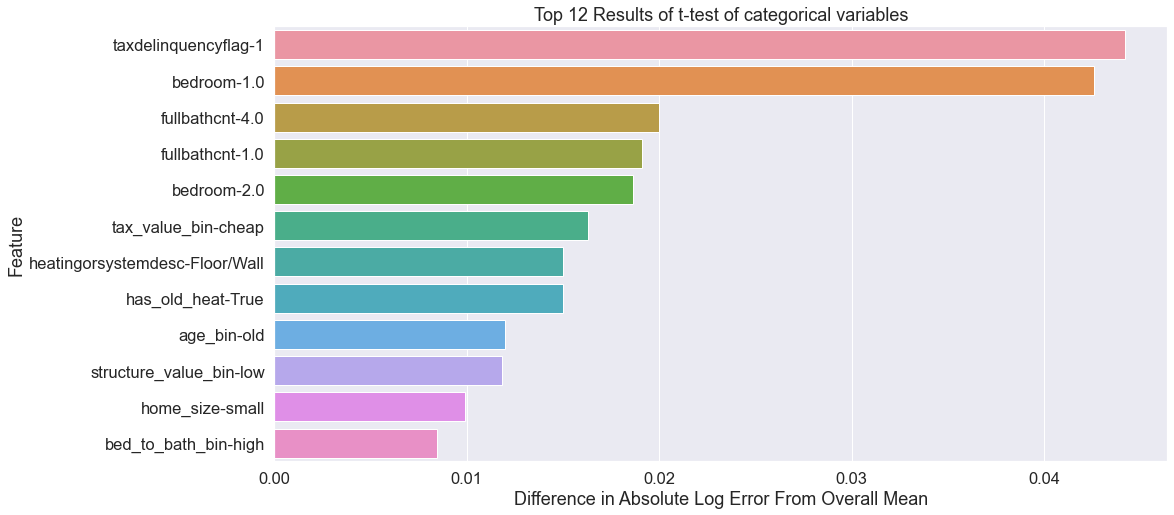

In [6]:
sns.barplot(data = high_log_errors.head(12), y = 'column_option', x = 'difference_from_overall')
plt.title('Top 12 Results of t-test of categorical variables')
plt.xlabel('Difference in Absolute Log Error From Overall Mean')
plt.ylabel('Feature')
plt.show()

### Clustered different combinations of categories from the top 12 chart of greatest absolute log error difference:
- Old, Small, low tax value houses with outdated heating systems (age, square feet, tax value, heating system)
- Cheap structure and land valued homes (structure dollar per sqft, land dollar per sqft)
- High full bath counts and high bed to bath houses (fullbathcnt and bed_bath_ratio)
- Tax delinquent, smaller bathrooms counts (2 or less), cheaper tax values

In [7]:
# Scale required columns
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['age','square_feet','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft','fullbathcnt','bed_bath_ratio','bathroom'])

## Cluster on age, square feet, tax value, and old heat

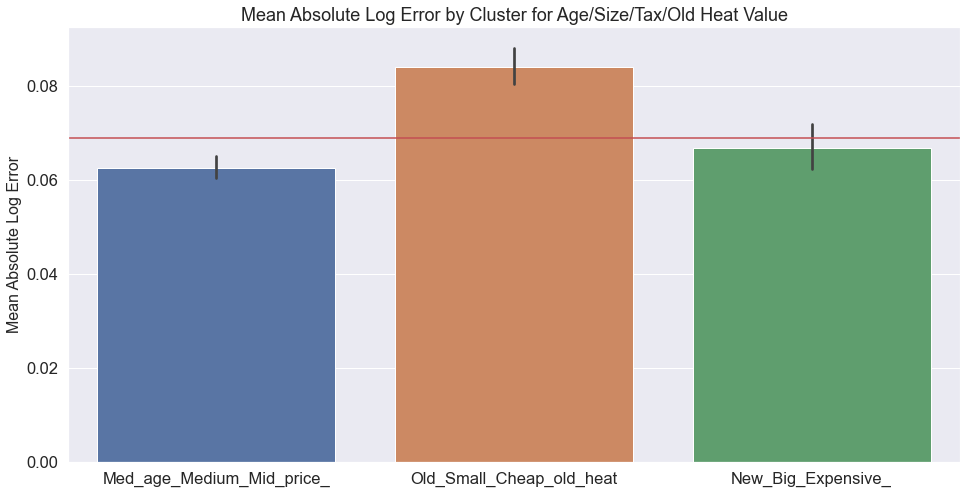

In [8]:
features_to_cluster = ['age_scaled','square_feet_scaled','tax_value_scaled','has_old_heat']
train_scaled, validate_scaled, test_scaled = model.perform_cluster_analysis(train_scaled, validate_scaled, test_scaled, features_to_cluster, plots = False)

train_scaled = model.rename_cluster_1(train_scaled)
validate_scaled = model.rename_cluster_1(validate_scaled)
test_scaled = model.rename_cluster_1(test_scaled)
    
sns.barplot(data = train_scaled, x = 'age_squ_tax_has_cluster', y='abs_logerror')
plt.axhline(train_scaled.abs_logerror.mean(), color='r')
plt.title(f"Mean Absolute Log Error by Cluster for Age/Size/Tax/Old Heat Value")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.show()

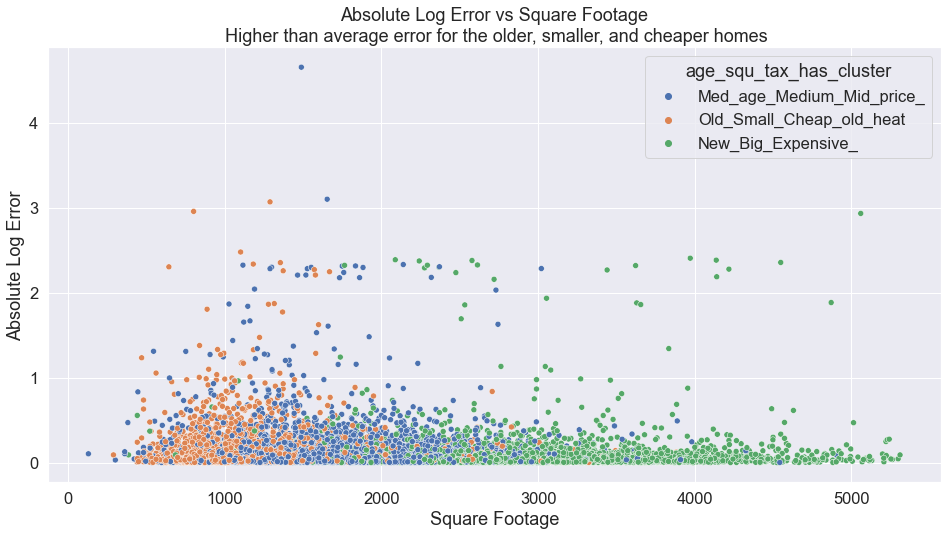

In [9]:
sns.scatterplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='age_squ_tax_has_cluster')
plt.title("Absolute Log Error vs Square Footage\n Higher than average error for the older, smaller, and cheaper homes")
plt.ylabel('Absolute Log Error')
plt.xlabel('Square Footage')
plt.show()

### Three cluster identified as:
- New, Big, High Tax Value, Newer heat
- Old, Small, Low Tax Value, Older heat 
    + This cluster showed statistically significant higher than average absolute log error
- Medium age, Medium size, Lower tax value, Newer heat 
    + This cluster showed statistically significant lower than average absolute log error error 

### Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. Perhaps the prediction model does not handle values outside the mean very well.

## Cluster on structure value, land value and tax delinquency

Text(0.5, 0, '')

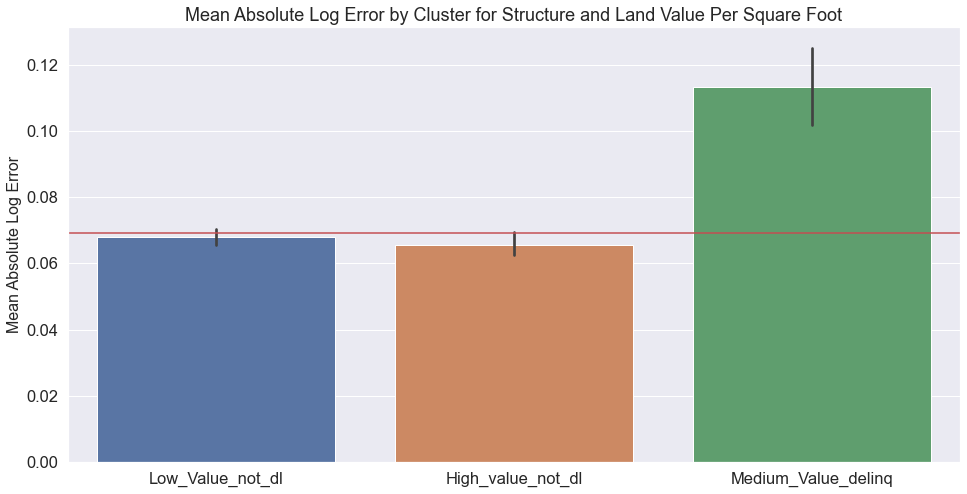

In [10]:
features_to_cluster = ['structure_dollar_per_sqft_scaled','land_dollar_per_sqft_scaled','taxdelinquencyflag']
train_scaled, validate_scaled, test_scaled = model.perform_cluster_analysis(train_scaled, validate_scaled, test_scaled, features_to_cluster, cluster_qty = 3, plots=False)


train_scaled = model.rename_cluster_2(train_scaled)
validate_scaled = model.rename_cluster_2(validate_scaled)
test_scaled = model.rename_cluster_2(test_scaled)

sns.barplot(data = train_scaled, x = 'str_lan_tax_cluster', y='abs_logerror')
plt.axhline(train_scaled.abs_logerror.mean(), color='r')
plt.title(f"Mean Absolute Log Error by Cluster for Structure and Land Value Per Square Foot")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

In [11]:
# sns.relplot(data = train_scaled, x = 'land_dollar_per_sqft', y='abs_logerror', hue='str_lan_tax_cluster', height = 10)#, col = 'taxdelinquencyflag')

### Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.

## Cluster on full bath count and bed to bath ratio

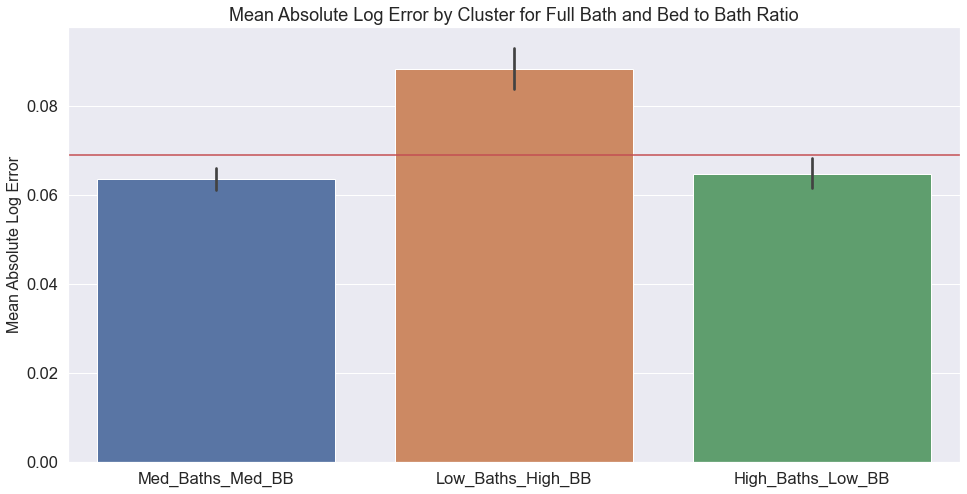

In [12]:
features_to_cluster = ['fullbathcnt_scaled','bed_bath_ratio_scaled']
train_scaled, validate_scaled, test_scaled = model.perform_cluster_analysis(train_scaled, validate_scaled, test_scaled, features_to_cluster, cluster_qty=3, plots=False)

train_scaled = model.rename_cluster_3(train_scaled)
validate_scaled = model.rename_cluster_3(validate_scaled)
test_scaled = model.rename_cluster_3(test_scaled)
                                                                                  
sns.barplot(data = train_scaled, x = 'ful_bed_cluster', y='abs_logerror')
plt.axhline(train_scaled.abs_logerror.mean(), color='r')
plt.title(f"Mean Absolute Log Error by Cluster for Full Bath and Bed to Bath Ratio")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.show()

- Few full baths, low bed to bath ratios
- Medium full baths, Medium bed to bath ratios (number of full baths ~= number of beds)
- Few full baths, high bed to bath ratios
    + statistically significant mean abs log error above overall average

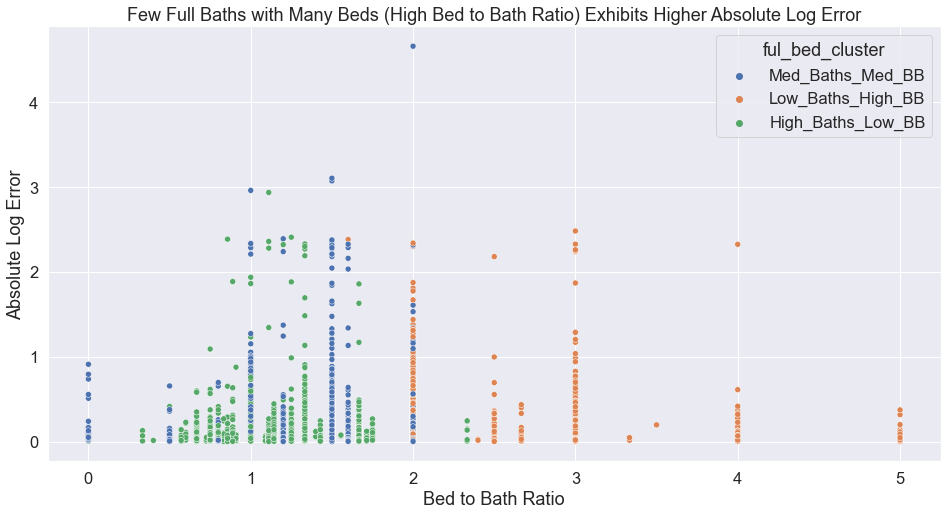

In [13]:
sns.scatterplot(data = train_scaled, x = 'bed_bath_ratio', y='abs_logerror', hue='ful_bed_cluster')
plt.title("Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error")
plt.ylabel('Absolute Log Error')
plt.xlabel('Bed to Bath Ratio')
plt.show()

### Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error

## Cluster by tax delinquency, bathroom, tax values

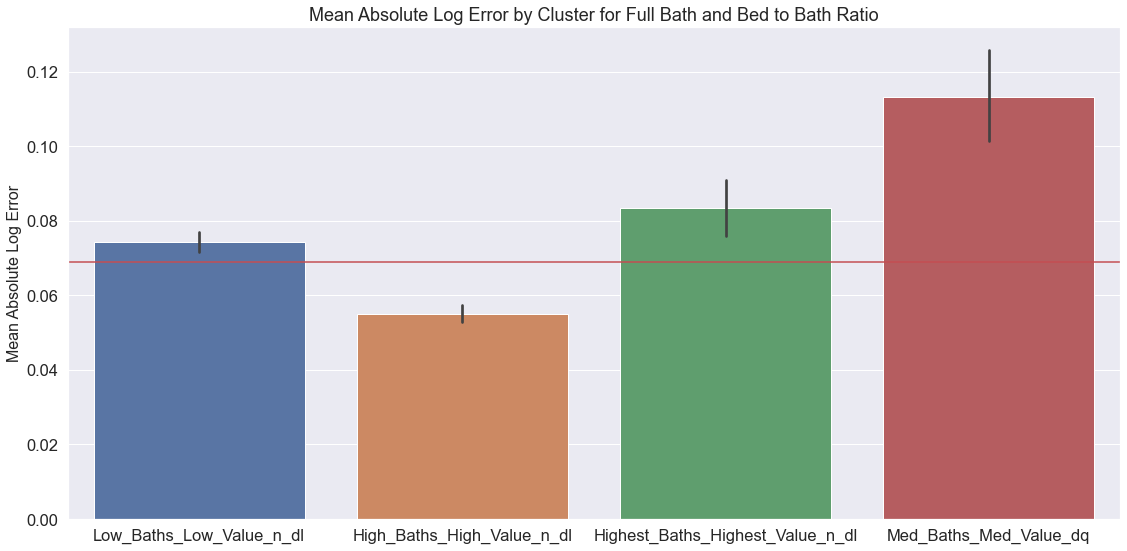

In [14]:
features_to_cluster = ['taxdelinquencyflag','bathroom_scaled','tax_value_scaled']
train_scaled, validate_scaled, test_scaled = model.perform_cluster_analysis(train_scaled, validate_scaled, test_scaled, features_to_cluster,cluster_qty=4, plots=False)


train_scaled = model.rename_cluster_4(train_scaled)
validate_scaled = model.rename_cluster_4(validate_scaled)
test_scaled = model.rename_cluster_4(test_scaled)

sns.barplot(data = train_scaled, x = 'tax_bat_tax_cluster', y='abs_logerror')
plt.axhline(train_scaled.abs_logerror.mean(), color='r')
plt.title(f"Mean Absolute Log Error by Cluster for Full Bath and Bed to Bath Ratio")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.tight_layout()

In [15]:
# sns.relplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='tax_bat_tax_cluster', height = 10, col='taxdelinquencyflag')
# plt.ylabel('Absolute Log Error')
# plt.xlabel('Square Footage')
# plt.show()

### Clusters are:
- Low Bath, Low Tax Value
- Medium Bath, Medium Tax Value and tax delinquent
    + Statistically significant higher than average log error 
- High Bath, High Tax Value
    + Statistically significant higher than average log error 
- Highest Bath, Highest Tax Value

### Tax Values and bathroom counts on both high and low ends of the range result in higher log errors. Tax delinquency has a strong effect on log error as originally shown via t-test results.

## Exploration Summary:
- Size, age, tax value and tax delinquency have the greatest affect on absolute log error.
- Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 
- Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.
- Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error
- Tax Values and bathroom counts on both high and low ends of the range result in higher log errors. Tax delinquency has a strong effect on log error as originally shown via t-test results.

## Regression Modeling
- Attempt to predict log error based on results from exploration
- Top features for model selection: 
    - age
    - size
    - tax value
    - tax delinquency status
    - bathroom count (correlated with size)

In [16]:
# Add results of clusters to the data sets
clusters_to_add = ['age_squ_tax_has_cluster', 'str_lan_tax_cluster', 'ful_bed_cluster', 'tax_bat_tax_cluster']

for cluster in clusters_to_add:
    train[cluster] = train_scaled[cluster]
    validate[cluster] = validate_scaled[cluster]
    test[cluster] = test_scaled[cluster]

In [17]:
# These are the features that need to be scaled
features_to_scale = ['age','square_feet','bathroom','bedroom','tax_value','land_dollar_per_sqft','structure_dollar_per_sqft', 'bed_bath_ratio']
# These are the features that will be fed into the model based on exploration
columns_to_use = ['age','square_feet','bathroom','bedroom','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft', 'bed_bath_ratio','taxdelinquencyflag',
        'has_old_heat']
# These are the features that need dummy variables
to_dummy=['fullbathcnt_bin', 'age_bin','tax_value_bin', 'lot_size_bin',
       'bed_to_bath_bin', 'structure_value_bin', 'land_value_bin', 'age_squ_tax_has_cluster',
       'str_lan_tax_cluster', 'ful_bed_cluster', 'tax_bat_tax_cluster']
# Test each county with each regression algorithm
all_results = {}

# Perform scaling
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = model.data_scaling(train, validate, test, to_dummy, features_to_scale, columns_to_use)

# Perform feature selection
rfe_features = model.model_feature_selection(X_train_scaled, y_train, 5)

## Some clusters come out as top features

In [18]:
print(rfe_features)

['taxdelinquencyflag', 'has_old_heat', 'age_squ_tax_has_cluster_Old_Small_Cheap_old_heat', 'str_lan_tax_cluster_Medium_Value_delinq', 'tax_bat_tax_cluster_Med_Baths_Med_Value_dq']


In [19]:
# Save results from fitting and predicting to a dictionary
model_results = model.model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features=rfe_features, show_test = True, print_results = False)

### Sorted model results by RMSE value on validate, choose top performing model and evaluate on test

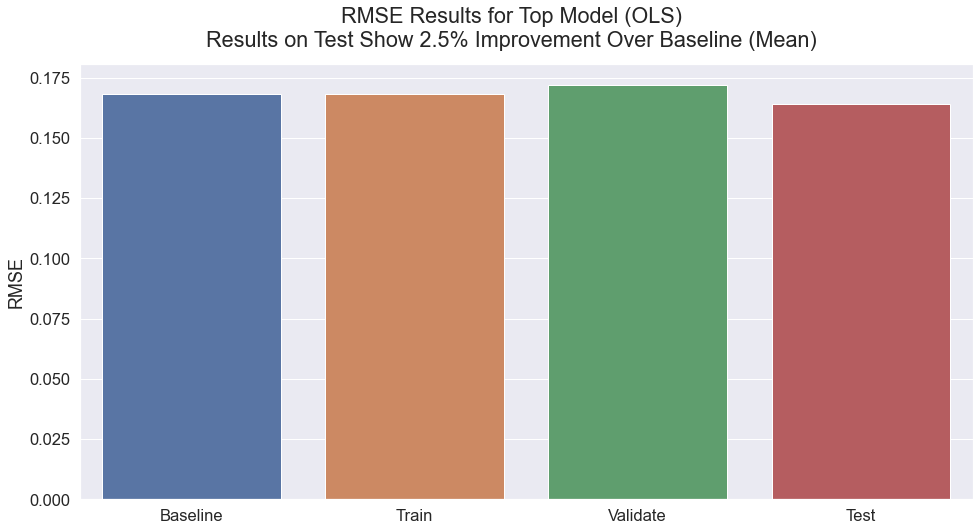

In [20]:
# Plot modeling results for top model. Top model chosen based on rmse score on validate (and confirming not overfit)
top = model_results.sort_values(by='rmse_validate',ascending=True).iloc[2:].head(1)
sns.barplot(x = ['Baseline','Train','Validate','Test'], y = [model_results.loc['log_error_pred_mean']['rmse_train'], top.rmse_train.values[0], top.rmse_validate.values[0],top.rmse_test.values[0]])
# Calculate improvement in performance on test vs baseline
test_improvement = (model_results.loc['log_error_pred_mean']['rmse_train']-top.rmse_test.values[0])/model_results.loc['log_error_pred_mean']['rmse_train']
plt.suptitle(f'RMSE Results for Top Model (OLS)\nResults on Test Show {test_improvement:.1%} Improvement Over Baseline (Mean)')
plt.ylabel('RMSE')
plt.show()

## Modeling takeaways:
- Small rise in RMSE from train to validate but does not look like significant overfitting is happening
- The OLS model performed the best based on RMSE validate score, and when evaluated using the test set showed a ~2.5% improvement for predicting log error over baseline
- Other models were very close in performance to OLS
- The high RMSE and r2 values show that log error cannot be effectively modeled using linear regression using these features and parameters; further refinement work is necessary to improve the model.

# Conclusion

- Based on the key findings demonstrated in this project the Zestimate needs to be improved for homes with the following factors:
    - small size
    - low tax value
    - medium structure and land values
    - older homes
    - high bed to bath ratios
- Homes with tax delinquency show very high log errors relative to the average
    - If the current model uses data from recent tax records then it will need to be adjusted for these homes
- The OLS model performed the best based on RMSE validate score, and when evaluated using the test set showed a ~2.5% improvement for predicting log error over baseline
- Other models were very close in performance to OLS
- The high RMSE and r2 values show that log error cannot be effectively modeled using linear regression using these features and parameters; further refinement work is necessary to improve the model.
- Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 
- Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.
- Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error


## Future work:
- Explore other factors that may affect log errors
- Create additional features for modeling
- Perform additional feature engineering work 
- Test additional hyperparameters for the models